In [2]:
!pip install datasets torch
!pip install accelerate -U
!pip install transformers -U

In [3]:
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

1. Model Training and Validation
Fine-tune the GPT-2 model on the Tiny Shakespeare dataset. As you train the model, plot the
validation loss against the number of training epochs. You should provide figures showing this
relationship for 30 epochs of training


In [4]:
# https://pypi.org/project/tinyshakespeareloader/
from datasets import load_dataset

# dataset = load_dataset("Trelis/tiny-shakespeare")
dataset = load_dataset("tiny_shakespeare")
dataset

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for tiny_shakespeare contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tiny_shakespeare
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

In [6]:
from transformers import GPT2Tokenizer
from datasets import load_dataset

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the padding token to EOS token if it's not already set
# This is important!!
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define the tokenize function
def tokenize_function(examples):
    # Tokenize the inputs and labels
    return tokenizer(examples['text'], max_length=512, truncation=True, padding="max_length")

# Apply the tokenize function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=dataset['train'].column_names)


In [7]:
from transformers import GPT2LMHeadModel #give the last layer
from transformers import GPT2Tokenizer

# Load the pre-trained GPT-2 model
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Resize the token embeddings in case you added special tokens
model.resize_token_embeddings(len(tokenizer))

Embedding(50257, 768)

In [8]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',         # Directory for saving trained model
    num_train_epochs=30,             # Number of training epochs

    learning_rate=3e-4,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Weight decay to prevent overfitting

    logging_dir='./logs',            # Directory for storing logs
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save the model at the end of each epoch
    load_best_model_at_end=True,     # Load the best model at the end of training
    logging_steps=1,                 # Log every 100 steps
    logging_strategy='epoch'         # Log after each step
)

## make check point each 10 epoch -- save directly save check point for each epoch -- load model from 10th epoch -> pass the data want to

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Important: GPT-2 should not use masked language modeling
)

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    data_collator=data_collator,
)

In [9]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,4.271700,3.979211
2,4.269900,3.964512
3,4.409200,3.935642
4,4.554800,3.893234
5,4.274100,3.835835
6,4.272500,3.768748
7,4.210900,3.699411
8,3.910900,3.632016
9,4.010800,3.565544
10,3.981000,3.505051


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=30, training_loss=3.7346433877944945, metrics={'train_runtime': 511.7082, 'train_samples_per_second': 0.059, 'train_steps_per_second': 0.059, 'total_flos': 7838760960000.0, 'train_loss': 3.7346433877944945, 'epoch': 30.0})

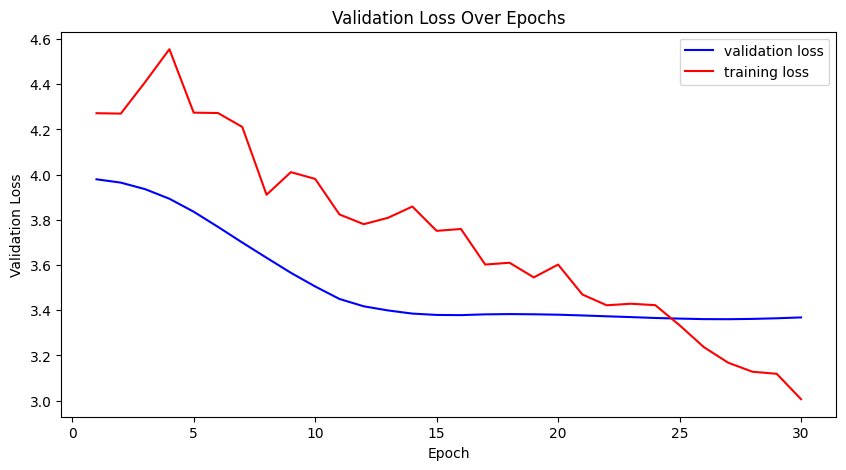

In [10]:
import matplotlib.pyplot as plt

# Accessing the history of the training statistics
metrics = trainer.state.log_history

# Filtering out the validation losses
validation_loss = [log['eval_loss'] for log in metrics if 'eval_loss' in log]
training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]

epochs = range(1, len(validation_loss) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, validation_loss, color='b', label='validation loss')
plt.plot(epochs, training_loss, color='r', label='training loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()
## case of over-fitting = over training
# loss = trustworkthy - expected generated text is bad -- trust loss function

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
model.save_pretrained('/content/drive/MyDrive/colab-models/gpt2_tiny_shakespeare_30epochs')
# model.save_pretrained('/content/drive/MyDrive/colab-models/gpt2_tiny_shakespeare_10epochs')

## 2. Text Generation
Generate text using the prompts

***“To be or not to be”***

***“A horse! a horse! my kingdom for a
horse!”***


Perform this task under the following conditions:

a) Using the original, pre-trained GPT-2 model without any fine-tuning

b) Using the fine-tuned model after 10 epochs.

c) Using the fine-tuned model after 30 epochs.


In [47]:
new_text = 'to be or not to be'
new_text_2 = 'A horse! a horse! my kingdom for a horse!'
input_ids = tokenizer.encode(new_text, return_tensors="pt").to(device)
input_ids_2 = tokenizer.encode(new_text_2, return_tensors="pt").to(device)

In [57]:
# a) Using the original, pre-trained GPT-2 model without any fine-tuning
model_a = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
output = model_a.generate(input_ids, max_length=50)
no_fine_1 = tokenizer.decode(output[0], skip_special_tokens=True)
output = model_a.generate(input_ids_2, max_length=100)
no_fine_2 = tokenizer.decode(output[0], skip_special_tokens=True)
print(no_fine_2)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


A horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a


In [49]:
# b) Using the fine-tuned model after 10 epochs.
model_b = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/colab-models/gpt2_tiny_shakespeare_10epochs').to(device)
output = model_b.generate(input_ids, max_length=50)
epochs_10_1 = tokenizer.decode(output[0], skip_special_tokens=True)
output = model_b.generate(input_ids_2, max_length=30)
epochs_10_2 = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [55]:
# c) Using the fine-tuned model after 30 epochs.
model_c = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/colab-models/gpt2_tiny_shakespeare_30epochs').to(device)
output = model_c.generate(input_ids, max_length=50)
epochs_30_1 = tokenizer.decode(output[0], skip_special_tokens=True)
output = model_c.generate(input_ids_2, max_length=30)
epochs_30_2 = tokenizer.decode(output[0], skip_special_tokens=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [51]:
def print_msg_box(msg, indent=1, width=None, title=None):
    """Print message-box with optional title."""
    lines = msg.split('\n')
    space = " " * indent
    if not width:
        width = max(map(len, lines))
    box = f'╔{"═" * (width + indent * 2)}╗\n'  # upper_border
    if title:
        box += f'║{space}{title:<{width}}{space}║\n'  # title
        box += f'║{space}{"-" * len(title):<{width}}{space}║\n'  # underscore
    box += ''.join([f'║{space}{line:<{width}}{space}║\n' for line in lines])
    box += f'╚{"═" * (width + indent * 2)}╝'  # lower_border
    print(box)

In [52]:
print_msg_box(new_text)
print(f'=== original ===\n{no_fine_1}\n')
print(f'=== 10 epochs ===\n{epochs_10_1}\n')
print(f'=== 30 epochs] ===\n{epochs_30_1}\n')

print_msg_box(new_text_2)
print(f'=== original ===\n{no_fine_2}\n')
print(f'=== 10 epochs ===\n{epochs_10_2}\n')
print(f'=== 30 epochs] ===\n{epochs_30_2}\n')

╔════════════════════╗
║ to be or not to be ║
╚════════════════════╝
=== original ===
to be or not to be.

The first thing to do is to make sure that you are not using the wrong software.

If you are using a different software, you should be able to use it without any problems.



=== 10 epochs ===
to be or not to be.

The first thing to do is to make sure that you are not using the wrong language.

The second thing to do is to make sure that you are not using the wrong language.

The

=== 30 epochs] ===
to be or not to be a member of the Church.

The Church is not a body of men, but a body of women.

The Church is not a body of men, but a body of women.

The Church

╔═══════════════════════════════════════════╗
║ A horse! a horse! my kingdom for a horse! ║
╚═══════════════════════════════════════════╝
=== original ===
A horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a horse! a horse! my kingdom for a ho